In [273]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define the ticker and the time period
ticker = 'TSLA'
start_date = '2019-01-01'
end_date = '2020-01-01'

# Fetch TSLA data
tsla = yf.download(ticker, start=start_date, end=end_date)
print(tsla.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2019-01-02  20.406668  21.008667  19.920000  20.674667  20.674667  174879000
2019-01-03  20.466667  20.626667  19.825333  20.024000  20.024000  104478000
2019-01-04  20.400000  21.200001  20.181999  21.179333  21.179333  110911500
2019-01-07  21.448000  22.449333  21.183332  22.330667  22.330667  113268000
2019-01-08  22.797333  22.934000  21.801332  22.356667  22.356667  105127500


In [274]:
# Moving Average 
short_window = 40
long_window = 100

tsla['Short_MAvg'] = tsla['Close'].rolling(window=short_window, min_periods=1).mean()
tsla['Long_MAvg'] = tsla['Close'].rolling(window=long_window, min_periods=1).mean()

In [275]:
# Basic trading signal based on crossover 

# Create a 'Signal' column
tsla['Signal'] = 0
tsla['Signal'] = np.where(tsla['Short_MAvg'] > tsla['Long_MAvg'], 1, 0)

In [276]:
# Generate trading orders
tsla['Position'] = tsla['Signal'].diff()

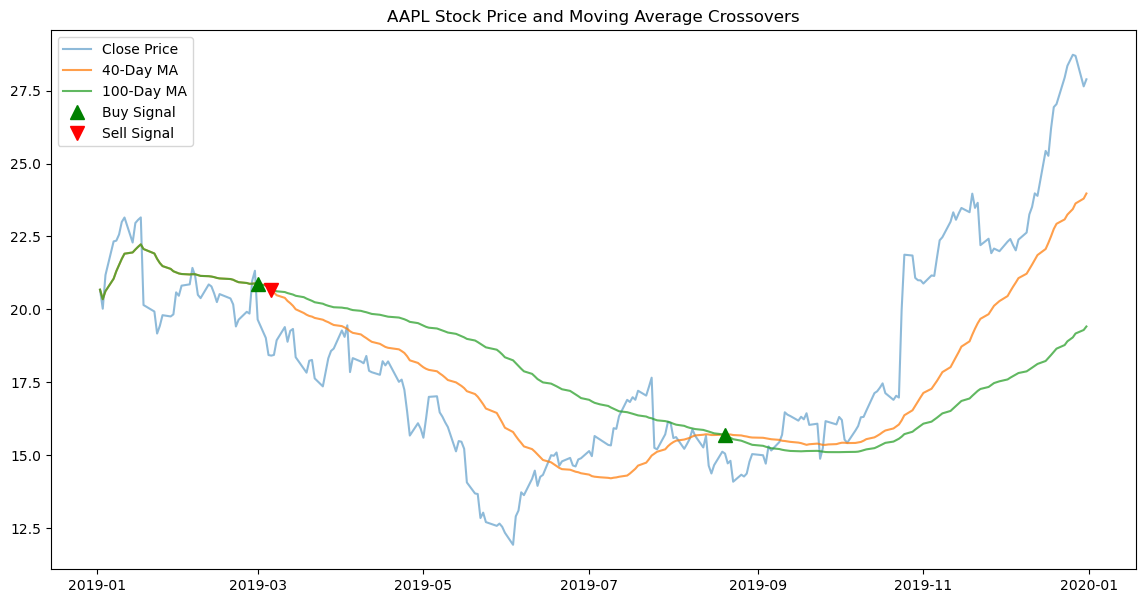

In [277]:
# Basic Back Test

# Plot the closing prices and moving averages
plt.figure(figsize=(14,7))
plt.plot(tsla['Close'], label='Close Price', alpha=0.5)
plt.plot(tsla['Short_MAvg'], label=f'{short_window}-Day MA', alpha=0.75)
plt.plot(tsla['Long_MAvg'], label=f'{long_window}-Day MA', alpha=0.75)

# Plot buy signals
plt.plot(tsla[tsla['Position'] == 1].index, tsla['Short_MAvg'][tsla['Position'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')

# Plot sell signals
plt.plot(tsla[tsla['Position'] == -1].index, tsla['Short_MAvg'][tsla['Position'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title('AAPL Stock Price and Moving Average Crossovers')
plt.legend()
plt.show()

In [278]:
tsla['Std_Dev'] = tsla['Close'].rolling(window=short_window, min_periods=1).std()

# Calculate the z-score
tsla['Z_Score'] = (tsla['Close'] - tsla['Short_MAvg']) / tsla['Std_Dev']

In [284]:
# Define thresholds for buying and selling
threshold_buy = -1.5  # Buy signal threshold
threshold_sell = 1.5  # Sell signal threshold

# Generate signals
tsla['Signal'] = 0
tsla['Signal'][tsla['Z_Score'] > threshold_sell] = -1  # Sell signal
tsla['Signal'][tsla['Z_Score'] < threshold_buy] = 1  # Buy signal

# Generate trading positions
tsla['Position'] = tsla['Signal'].replace(0, np.nan).ffill().fillna(0)

/var/folders/z3/mmqv83kn7gvb04yyy9l4n95w0000gn/T/ipykernel_47816/3368476749.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla['Signal'].loc[tsla['Z_Score'] > threshold_sell] = -1  # Sell signal
/var/folders/z3/mmqv83kn7gvb04yyy9l4n95w0000gn/T/ipykernel_47816/3368476749.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla['Signal'].loc[tsla['Z_Score'] < threshold_buy] = 1  # Buy signal


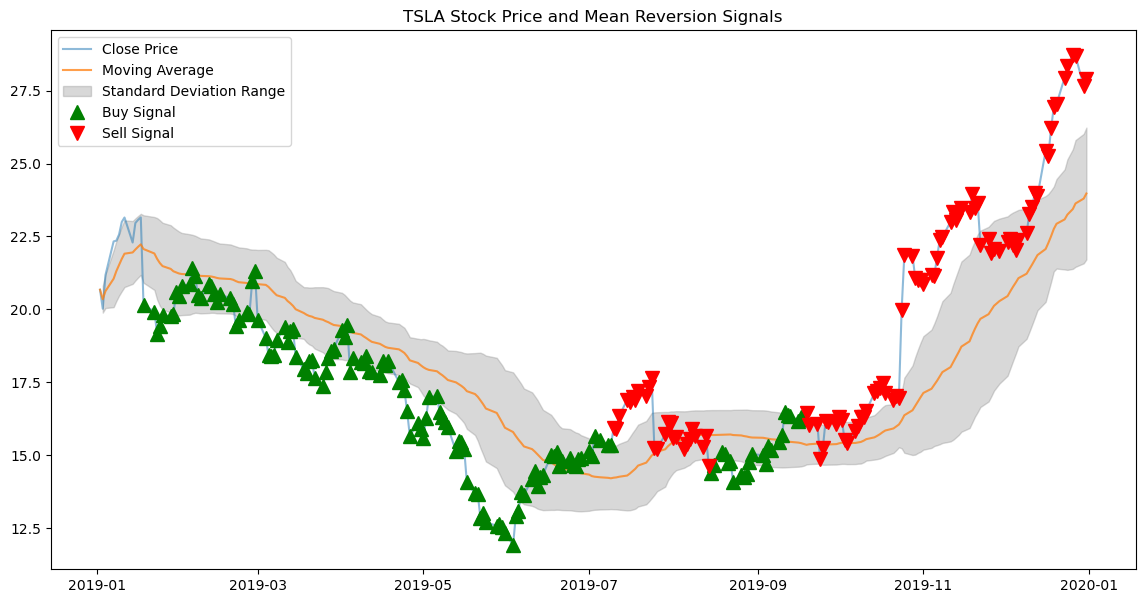

In [283]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(tsla['Close'], label='Close Price', alpha=0.5)
plt.plot(tsla['Short_MAvg'], label='Moving Average', alpha=0.75)
plt.fill_between(tsla.index, tsla['Short_MAvg'] - tsla['Std_Dev'], tsla['Short_MAvg'] + tsla['Std_Dev'], color='gray', alpha=0.3, label='Standard Deviation Range')

# Highlight the buy and sell signals
plt.plot(tsla[tsla['Position'] == 1].index, tsla['Close'][tsla['Position'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(tsla[tsla['Position'] == -1].index, tsla['Close'][tsla['Position'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title(f'{ticker} Stock Price and Mean Reversion Signals')
plt.legend()
plt.show()

In [434]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def train(model, ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    
    # Calculate moving averages and std
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['Std_Dev'] = data['Close'].rolling(window=20).std()

    # Calculate the z-score
    data['Z_Score'] = (data['Close'] - data['SMA_20']) / data['Std_Dev']

    # Calculate RSI
    delta = data['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up / ema_down

    data['RSI'] = 100 - (100 / (1 + rs))

    # Calculate the daily returns
    data['Returns'] = data['Close'].pct_change()

    # Drop any NaNs
    data.dropna(inplace=True)

    # If stock price goes up or down
    data['Target'] = (data['Returns'].shift(-1) > 0).astype(int)

    # Wanted features for X and y
    features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Returns']
    X = data[features]
    y = data['Target']

    # Split data into first 80% and last 20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate cumulative strategy returns on test data
    X_test['Predicted_Signal'] = y_pred
    X_test['Strategy_Returns'] = X_test['Returns'] * X_test['Predicted_Signal'].shift(1)
    cumulative_strategy_returns = (X_test['Strategy_Returns'] + 1).cumprod()

    # Calculate cumulative returns for the market
    spy = yf.download('SPY', start=X_test.index[0].date().strftime('%Y-%m-%d'), end=end_date)
    spy['Returns'] = spy['Close'].pct_change()
    cumulative_market_returns = (spy['Returns'] + 1).cumprod()
    
    plt.figure(figsize=(10,5))
    plt.plot(cumulative_strategy_returns, label='Strategy Returns')
    plt.plot(cumulative_market_returns, label='Market Returns')
    plt.legend()
    plt.show()

In [1]:
#| code-fold: true
%load_ext autoreload
%autoreload 2
from strategy import MeanReversion

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [46]:
ticker = 'AAPL'
market = 'SPY'
start = '2010-01-01'
end = '2020-01-01'
MR = MeanReversion(ticker, start, end, market)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Accuracy: 0.5040485829959515


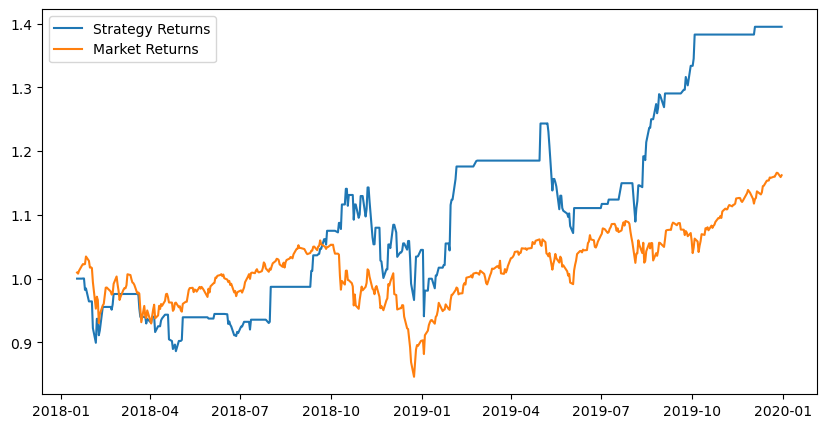

In [47]:
RF = RandomForestClassifier(n_estimators=100, random_state=42)
X_test = MR.evaluate(RF)

Accuracy: 0.4607438016528926


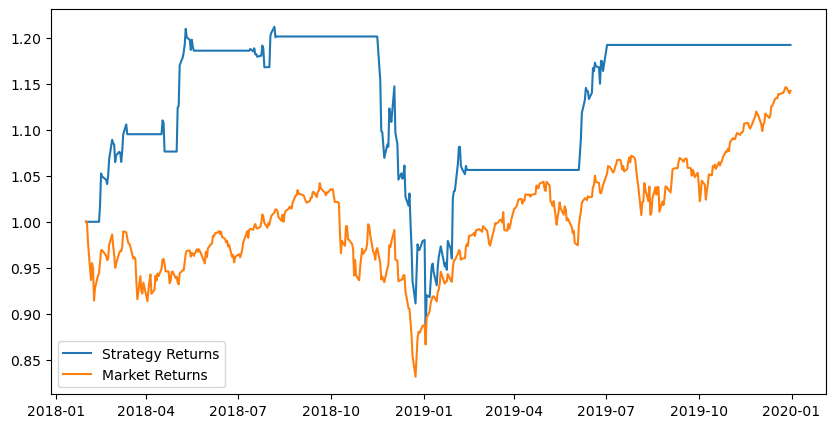

In [48]:
LR = LogisticRegression()
X_test = MR.evaluate(LR)

Accuracy: 0.5485232067510548


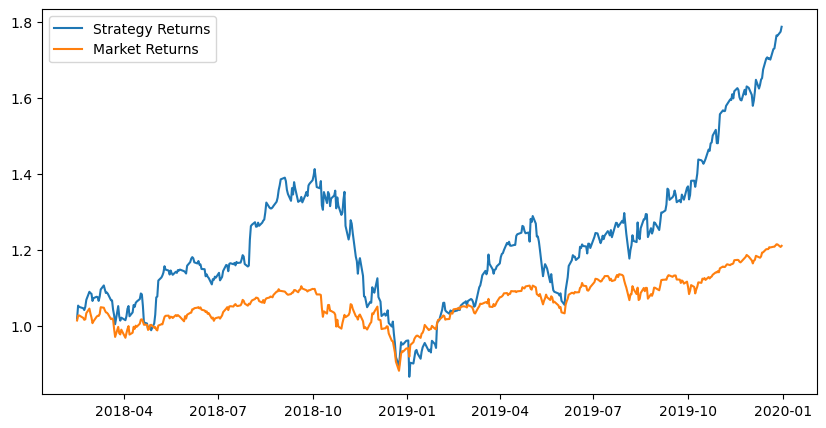

In [49]:
SVM = SVC()
X_test = MR.evaluate(model = SVM)

Code to calculate risk free rate. Used for calculating sharpe ratio.

In [42]:
def deannualize(annual_rate, periods=365):
    return (1 + annual_rate) ** (1/periods) - 1

def get_risk_free_rate(start_date, end_date):
    # download 3-month us treasury bills rates
    annualized = yf.download('^IRX', start_date, end_date)['Close']
    annualized = annualized / 100
    
    # de-annualize
    daily = annualized.apply(deannualize)

    # create dataframe
    return pd.DataFrame({"annualized": annualized, "daily": daily}) 